In [1]:
from skshapes.morphing import ElasticMetric, RigidMotion, ElasticMetric2
from skshapes.loss import OptimalTransportLoss, LandmarkLoss, NearestNeighborsLoss
from skshapes.data import read
from skshapes.tasks import DistanceMatrix, Registration, Registration2
import torch

In [1]:
## Rigid alignment (with landmarks)

from skshapes.data import read
from skshapes.tasks import Registration
from skshapes.morphing import RigidMotion
from skshapes.loss import LandmarkLoss
from skshapes.optimization import LBFGS
from skshapes.data import read

import torch
import os

targetfolder = "data/SCAPE_low_resolution_aligned"
datafolder = "data/SCAPE_low_resolution"

files = os.listdir(datafolder)
reference = read(datafolder + "/" + files[0])
rest = [read(datafolder + "/" + file) for file in files[1:]]

N = reference.points.shape[0]
reference.landmarks = torch.arange(N, dtype=torch.int64)
reference.to_pyvista().save(targetfolder + "/" + files[0])

for i, mesh in enumerate(rest):
    print("Aligning " + files[i + 1] + " to " + files[0] + "...")
    mesh.landmarks = torch.arange(N, dtype=torch.int64)

    r = Registration(
        model=RigidMotion(),
        loss=LandmarkLoss(p=2),
        optimizer=LBFGS(),
        verbose=0,
        n_iter=2,
        device="cpu",
    )

    morphed = r.fit_transform(source=mesh, target=reference)
    morphed.to_pyvista().save(targetfolder + "/" + files[i + 1])

Aligning mesh005.ply to mesh047.ply...
Aligning mesh001.ply to mesh047.ply...
Aligning mesh042.ply to mesh047.ply...
Aligning mesh027.ply to mesh047.ply...
Aligning mesh003.ply to mesh047.ply...
Aligning mesh023.ply to mesh047.ply...
Aligning mesh026.ply to mesh047.ply...
Aligning mesh022.ply to mesh047.ply...
Aligning mesh028.ply to mesh047.ply...
Aligning mesh033.ply to mesh047.ply...
Aligning mesh021.ply to mesh047.ply...
Aligning mesh044.ply to mesh047.ply...
Aligning mesh004.ply to mesh047.ply...
Aligning mesh024.ply to mesh047.ply...
Aligning mesh070.ply to mesh047.ply...
Aligning mesh029.ply to mesh047.ply...
Aligning mesh034.ply to mesh047.ply...
Aligning mesh011.ply to mesh047.ply...
Aligning mesh048.ply to mesh047.ply...
Aligning mesh012.ply to mesh047.ply...
Aligning mesh068.ply to mesh047.ply...
Aligning mesh052.ply to mesh047.ply...
Aligning mesh000.ply to mesh047.ply...
Aligning mesh065.ply to mesh047.ply...
Aligning mesh018.ply to mesh047.ply...
Aligning mesh032.ply to m

In [1]:
##### ICP

rotation = 1

from skshapes.data import read, PolyData
from skshapes.loss import NearestNeighborsLoss
from skshapes.morphing import RigidMotion
from skshapes.tasks import Registration
from skshapes.optimization import LBFGS

import torch

# Load a mesh and apply a rotation
mesh = read("data/SCAPE_low_resolution/mesh000.ply")
mesh.to_pyvista().save("source.vtk")

rotation = 5
r = RigidMotion()
parameter = torch.Tensor([[rotation, rotation, rotation], [0, 0, 0]])
newmesh = r.morph(shape=mesh, parameter=parameter).morphed_shape
newmesh.to_pyvista().save("target.vtk")


source = read("source.vtk")
target = read("target.vtk")

source.landmarks = torch.arange(source.points.shape[0], dtype=torch.int64)
target.landmarks = torch.arange(target.points.shape[0], dtype=torch.int64)

r = Registration(
    model=RigidMotion(),
    loss=NearestNeighborsLoss(),
    optimizer=LBFGS(),
    verbose=1,
    n_iter=5,
    device="cpu",
)

morphed = r.fit_transform(source=source, target=target)
morphed.to_pyvista().save("output.vtk")

[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : at least one of the input tensors is not contiguous. Consider using contiguous data arrays to avoid unnecessary copies.
[pyKeOps] Warning : 

In [1]:
# Elastic registration (with landmarks)

from skshapes.data import read
from skshapes.loss import LandmarkLoss
from skshapes.morphing import ElasticMetric
from skshapes.tasks import Registration
from skshapes.optimization import LBFGS

import torch
import os

datafolder = "data/SCAPE_low_resolution_aligned"

source = read(datafolder + "/" + "mesh001.ply")
target = read(datafolder + "/" + "mesh041.ply")

source.landmarks = torch.arange(source.points.shape[0], dtype=torch.int64)
target.landmarks = torch.arange(target.points.shape[0], dtype=torch.int64)

from time import time

start = time()
r = Registration(
    model=ElasticMetric(n_steps=10),
    loss=LandmarkLoss(),
    optimizer=LBFGS(),
    verbose=1,
    n_iter=5,
    regularization=100,
    device="cpu",
)
newshape = r.fit_transform(source=source, target=target)
print(time() - start)

Loss value at iteration 0 : 5.045347213745117
Loss value at iteration 1 : 0.05011105164885521
Loss value at iteration 2 : 0.05011105164885521
Loss value at iteration 3 : 0.05011105164885521
Loss value at iteration 4 : 0.05011105164885521
0.27788662910461426


In [1]:
from skshapes.preprocessing import (
    LandmarkSetter,
    Pipeline,
    Decimation,
    AffineTransformation,
)
from skshapes.data import read
import os

# Read the shapes
datafolder = "/home/GitHub/scikit-shapes-draft/data/SCAPE/decimated/"
shapes = [read(datafolder + "/" + f"aligned_mesh{i:03d}.ply") for i in range(4)]

# Create a pipeline of preprocessing steps
preprocessing = Pipeline(
    steps=[
        LandmarkSetter(landmarks=[[0, 1], [2, 3], [4, 5], [6, 70]], by_indices=True),
        Decimation(target_reduction=0.95),
        AffineTransformation(matrix=[[2, 0, 0], [0, 2, 0], [0, 0, 2]]),
    ]
)

# Apply the preprocessing pipeline to the shapes and get the dataset
dataset = preprocessing.fit_transform(shapes=shapes)

for i in range(len(dataset)):
    print("Size of shape {} : {}".format(i, dataset[i].points.shape))
    print("Landmarks of shape {} : {}".format(i, dataset.landmarks[i]), end="\n\n")

ImportError: cannot import name 'Shape' from 'skshapes.data' (/home/GitHub/scikit-shapes/skshapes/data/__init__.py)

In [1]:
import torch


def barycentric_coordinates(mesh, point):
    # Compute the vectors from the point to the vertices
    vertices = mesh.points
    vectors = vertices - point
    norms = torch.norm(vectors, dim=1)

    tol = 1e-5  # TODO tol can be computed from the mesh resolution ?

    # Test if a vector is zero (that means the point is a vertex of the mesh)
    if torch.sum(vectors.abs().sum(dim=1) < tol):
        indice = torch.where(
            torch.all(torch.eq(vectors, torch.zeros_like(vectors)), dim=1)
        )[0]
        vertex_indice = int(indice[0])
        print(
            "The point is a vertex of the mesh, at the following indice: {}".format(
                vertex_indice
            )
        )
        return (torch.tensor(1.0), torch.tensor([vertex_indice]))

    else:
        # Normalize the vectors
        vectors /= norms.reshape(-1, 1)

        A = mesh.edges[0]
        B = mesh.edges[1]

        cos_angles = (vectors[A] * vectors[B]).sum(dim=1)
        # If cos(angle) = -1 <=> angle = pi, the point is on an edge

        if torch.sum((cos_angles - (-1)).abs() < tol):
            indice = torch.where((cos_angles - (-1)).abs() < tol)[0]
            edge_indice = int(indice[0])
            print(
                "The point is on an edge of the mesh, at the following indice: {}".format(
                    edge_indice
                )
            )

            # Coordinates
            a, b = mesh.edges[:, edge_indice]
            alpha = norms[b] / torch.norm(vertices[a] - vertices[b])
            beta = norms[a] / torch.norm(vertices[a] - vertices[b])
            assert torch.abs(alpha + beta - 1) < tol
            assert (
                (alpha * vertices[a] + beta * vertices[b]) - point
            ).abs().sum() < tol
            return (torch.tensor([alpha, beta]), torch.tensor([a, b]))

        else:
            A = mesh.triangles[0]
            B = mesh.triangles[1]
            C = mesh.triangles[2]

            angles_1 = torch.acos((vectors[A] * vectors[B]).sum(dim=1))
            angles_2 = torch.acos((vectors[B] * vectors[C]).sum(dim=1))
            angles_3 = torch.acos((vectors[C] * vectors[A]).sum(dim=1))

            sum_angles = angles_1 + angles_2 + angles_3
            # If sum_angles is close to 2pi, the point is inside the triangle, or its projection is inside the triangle

            if torch.sum((sum_angles - (2 * torch.pi)).abs() < tol):
                indices = torch.where((sum_angles - (2 * torch.pi)).abs() < tol)[0]
                # If several indices, we must find the one for which the point is inside irself the triangle, and not only its projection
                for i in indices:
                    a, b, c = mesh.triangles[:, i]
                    normals = mesh.triangle_normals[i]

                    if (
                        torch.abs(vectors[a] @ normals.T)
                        + torch.abs(vectors[b] @ normals.T)
                        + torch.abs(vectors[c] @ normals.T)
                        < tol
                    ):
                        indice_triangle = i

                print(
                    "The point is inside a triangle of the mesh, at the following indice: {}".format(
                        indice_triangle
                    )
                )
                # Coordinates
                a, b, c = mesh.triangles[:, indice_triangle]
                mat = torch.cat((vertices[a], vertices[b], vertices[c])).reshape(3, 3).T
                alpha, beta, gamma = torch.inverse(mat) @ point
                assert torch.abs(alpha + beta + gamma - 1) < tol
                assert (
                    (alpha * vertices[a] + beta * vertices[b] + gamma * vertices[c])
                    - point
                ).abs().sum() < tol
                return (torch.tensor([alpha, beta, gamma]), torch.tensor([a, b, c]))

            else:
                print("The point is outside the mesh.")

In [2]:
from skshapes.data import read

mesh = read("data/SCAPE_low_resolution/mesh000.ply")

vertices = mesh.points
e0, e1 = mesh.edges[:, 45]
point_edge = (mesh.points[e0] + 4 * mesh.points[e1]) / 5
a, b, c = mesh.triangles[:, 100]
point_triangle = (mesh.points[a] + 4 * mesh.points[b] + 2 * mesh.points[c]) / 7
point_vertice = mesh.points[42]

point = point_vertice

barycentric_coordinates(mesh, point)

The point is a vertex of the mesh, at the following indice: 42


(tensor(1.), tensor([42]))

In [138]:
from typing import NamedTuple

from skshapes._typing import *


class test(NamedTuple):
    a: int = 0
    b: int = 2


t = test()
t.b

2

In [42]:
import torch

a = torch.load("landmarks.pt")

In [47]:
landmark0 = a[1]

Indices : tensor([[73, 94, 92, 73, 75, 94, 62, 73],
        [ 0,  0,  0,  1,  1,  1,  2,  3]])
Values : tensor([0.2522, 0.3066, 0.4412, 0.0768, 0.6896, 0.2336, 1.0000, 1.0000],
       dtype=torch.float64)


In [1]:
import torch

A = torch.Tensor([[1.0, 0, 0], [4.1, 0, 6.1], [0, 8.2, 0]])
type(A)
B = A.to_sparse_coo()

B.dtype

ModuleNotFoundError: No module named 'torch'

In [7]:
import skshapes

from skshapes.loss import L2Loss
from skshapes.data import read
from skshapes.morphing import ElasticMetric, RigidMotion
from skshapes.tasks import Registration
from skshapes.optimization import LBFGS
import vedo

vedo.settings.default_backend = "vtk"
from vedo.applications import Browser

# Load the shapes
source = read("data/SCAPE_low_resolution/mesh001.ply")
target = read("data/SCAPE_low_resolution/mesh041.ply")


def foo(model, loss, optimizer, regularization):
    r = Registration(
        model=model,
        loss=loss,
        optimizer=optimizer,
        n_iter=5,
        regularization=regularization,
        device="cpu",
    )

    newshape = r.fit_transform(source=source, target=target)

    print(r.parameter.device)
    print(source.device)

    a = model.morph(shape=source, parameter=r.parameter, return_path=True)

    meshes = a.path
    meshes.append(target)

    return meshes

    # plt = Browser([vedo.Mesh(m.to_pyvista()) for m in meshes], resetcam=0, axes=0)  # a vedo.Plotter
    # plt.show().close()


r = Registration(
    model=RigidMotion(),
    loss=L2Loss(),
    optimizer=LBFGS(),
    n_iter=2,
)

print(source.device)
print(target.device)

source = r.fit_transform(source=source, target=target)
source = source.to("cpu")

cpu
cpu


In [11]:
model = ElasticMetric(n_steps=5)
loss = L2Loss()
optimizer = LBFGS()

meshes = foo(model, loss, optimizer, regularization=1000)

vedo.settings.default_backend = "vtk"
Browser([vedo.Mesh(m.to_pyvista()) for m in meshes], resetcam=0, axes=0).show().close()

cpu
cpu


In [4]:
from skshapes.loss import OptimalTransportLoss

loss = OptimalTransportLoss(loss="test")

In [2]:
# Load data
from skshapes.data import read
import pyvista
from skshapes.morphing import ElasticMetric, RigidMotion
from skshapes.loss import NearestNeighborsLoss, OptimalTransportLoss, LandmarkLoss
from skshapes.optimization import LBFGS

import vedo
from vedo.applications import Browser

source = read("data/SCAPE_low_resolution/mesh001.ply")
target = read("data/SCAPE_low_resolution/mesh041.ply")


# ElasticMetric can only be used with polydata
# RigidMotion can be used with all type of shapes


model = RigidMotion()
loss = NearestNeighborsLoss()
optimizer = LBFGS(model.parameters(), lr=0.1)

from skshapes.tasks import Registration


def foo(model, loss, optimizer, regularization):
    r = Registration(
        model=model,
        loss=loss,
        optimizer=optimizer,
        n_iter=5,
        device="cpu",
        regularization=regularization,
    )

    print(loss, model)
    newshape = r.fit_transform(source=source, target=target)

    parameter = r.parameter.detach().cpu().clone()
    n_frames = parameter.shape[0] + 1

    meshes = [source.copy(device="cpu") for _ in range(n_frames)]
    for i in range(n_frames - 1):
        meshes[i + 1].points = meshes[i].points + parameter[i]

    meshes = [vedo.Mesh(mesh.to_pyvista()) for mesh in meshes] + [
        vedo.Mesh(target.to_pyvista())
    ]

    plt = Browser(meshes, resetcam=0, axes=0)  # a vedo.Plotter
    plt.show().close()

In [2]:
# import modules and load a model
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [17]:
from skshapes.data import read
import pyvista
from skshapes.morphing import ElasticMetric
from skshapes.loss import L2Loss
from skshapes.optimization import SGD
from skshapes.tasks import Registration

import vedo
from vedo.applications import Browser

source = read("data/SCAPE_low_resolution/mesh001.ply")
target = read("data/SCAPE_low_resolution/mesh041.ply")


def foo(model, loss, optimizer, regularization):
    r = Registration(
        model=model,
        loss=loss,
        optimizer=optimizer,
        n_iter=2,
        device="cuda",
        regularization=regularization,
    )

    newshape = r.fit_transform(source=source, target=target)


model = ElasticMetric()
loss = L2Loss()
optimizer = SGD()


with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True
) as prof:
    with record_function("model_inference"):
        foo(model, loss, optimizer, regularization=10)


print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
prof.export_chrome_trace("trace.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         4.62%       2.538ms        67.49%      37.060ms      37.060ms       0.000us         0.00%     649.000us     649.000us             1  
                                Optimizer.step#SGD.step        39.87%      21.896ms        49.25%      27.044ms      13.522ms       0.000us         0.00%     424.000us     212.000us             2  
         

In [1]:
import pyvista
import numpy as np

from skshapes.data import PolyData

mesh = PolyData.from_pyvista(pyvista.Sphere())

n_points = mesh.n_points
n_triangles = mesh.n_triangles
n_edges = mesh.n_edges

n_landmarks = 10

landmarks_type = np.random.choice(["points", "edges", "triangles"], n_landmarks)

import torch

# Create landmarks (coo matrix)

In [1]:
import skshapes as sks
import pyvista

mesh = pyvista.Sphere()

test0 = sks.PolyData.from_pyvista(mesh)
test1 = sks.PolyData("data/SCAPE_low_resolution/mesh001.ply")
test2 = sks.PolyData("data/SCAPE_low_resolution/mesh001.ply").decimate(0.5)

be careful


In [2]:
print(test1.n_points)
print(test2.n_points)

127
65


In [3]:
import pyvista

sphere = pyvista.Sphere()
sphere.decimate(0.5).n_points

422

In [12]:
import numpy as np
import torch
import pyvista
import skshapes as sks

points = np.random.rand(100, 3)

points = np.concatenate([points, np.zeros((1, 3))], axis=0)
points.shape

pc = pyvista.PolyData(points, faces=[3, 0, 1, 2, 3, 1, 2, 3, 3, 0, 1, 2])

print(pc.is_all_triangles)
test = sks.PolyData(pc)

test.triangles

True <CallableBool>


tensor([[0, 1, 0],
        [1, 2, 1],
        [2, 3, 2]])

In [13]:
import numpy as np
import pyvista
import skshapes as sks


def test_mesh_cleaning():
    # Example of a mesh with duplicated points
    points = np.array(
        [
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 0],
            [1, 0, 0],
            [0, 0, 1],
        ],
        dtype=np.float64,
    )

    faces = np.array([3, 0, 1, 2, 3, 3, 4, 5])

    mesh = pyvista.PolyData(points, faces=faces)
    clean_mesh = mesh.clean()

    test = sks.PolyData(mesh)

    # Check that the mesh is cleaned when loaded by skshapes
    assert not np.allclose(test.points.numpy(), mesh.points)
    assert np.allclose(test.points.numpy(), clean_mesh.points)


test_mesh_cleaning()

AssertionError: 

In [40]:
torch.from_numpy(out[2][triangles])

tensor([[0, 0],
        [3, 3],
        [2, 1]])

In [9]:
test.clean().triangles

tensor([[0, 1, 0],
        [1, 2, 1],
        [2, 3, 2]])

In [15]:
used_points = np.union1d(np.unique(test.triangles), np.unique(test.edges))

In [17]:
unused_points = np.setdiff1d(np.arange(test.n_points), used_points)

In [18]:
unused_points

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [10]:
points_after

tensor([[0.8820, 0.9923, 0.9347],
        [0.9883, 0.9599, 0.1837],
        [0.8019, 0.0709, 0.0756],
        [0.4919, 0.0044, 0.1344]])

In [1]:
import skshapes as sks
import pyvista.examples


def test_registration_device():
    """This test ensure the behavior of the registration task with respect to the devices of the source, target and the gpu argument.
    Expected behavior:
        - If the gpu argument is True, the optimization should occurs on the gpu
        - If the gpu argument is False, the optimization should occurs on the gpu
        - The device of the output of .transform() and of .parameter_ should be the same as the device of the source and the target
        - If source.device != target.device, an error should be raised
    """

    shape1 = sks.PolyData(pyvista.Sphere())
    shape2 = sks.PolyData(pyvista.Sphere()).decimate(0.5)

    model = sks.RigidMotion()
    loss = sks.OptimalTransportLoss()
    optimizer = sks.LBFGS()

    for device in ["cpu", "cuda"]:
        for gpu in [False, True]:
            source = shape1.to(device)
            target = shape2.to(device)

            task = sks.Registration(
                model=model,
                loss=loss,
                optimizer=optimizer,
                n_iter=3,
                gpu=gpu,
                regularization=10,
                verbose=1,
            )

            newshape = task.fit_transform(source=source, target=target)

            # Check that the device on which the optimization is performed corresponds to the gpu argument
            if gpu:
                assert task.internal_parameter_device_type == "cuda"
            else:
                assert task.internal_parameter_device_type == "cpu"

            # Check that the device of the output is the same as the input's shapes
            assert task.parameter_.device.type == source.device.type
            assert newshape.device.type == target.device.type

    # Check that if source and target are on different devices, an error is raised
    source = shape1.to("cpu")
    target = shape2.to("cuda")
    try:
        task.fit(source=source, target=target)
    except:
        pass
    else:
        raise AssertionError("Should have raised an error")

Loss value at iteration 0 : 2.4044886231422424e-05
Loss value at iteration 1 : 2.4044886231422424e-05
Loss value at iteration 2 : 2.4044886231422424e-05
Loss value at iteration 0 : 2.6265159249305725e-05
Loss value at iteration 1 : 2.6265159249305725e-05
Loss value at iteration 2 : 2.6265159249305725e-05
Loss value at iteration 0 : 2.4044886231422424e-05
Loss value at iteration 1 : 2.4044886231422424e-05
Loss value at iteration 2 : 2.4044886231422424e-05
Loss value at iteration 0 : 2.6265159249305725e-05
Loss value at iteration 1 : 2.6265159249305725e-05
Loss value at iteration 2 : 2.6265159249305725e-05


In [11]:
list_of_losses = [
    i
    for i in sks.loss.__dict__.values()
    if isinstance(i, type) and issubclass(i, sks.Loss)
]
a = list_of_losses[0]()

In [16]:
source = shape1.to("cpu")
target = shape2.to("cuda")

list_of_losses = [
    i
    for i in sks.loss.__dict__.values()
    if isinstance(i, type) and issubclass(i, sks.Loss)
]
for loss in list_of_losses:
    l = loss()
    try:
        l(source=source, target=target)
    except:
        pass
    else:
        raise AssertionError("Should have raised an error")

In [16]:
import skshapes as sks

mesh = sks.PolyData("data/SCAPE_low_resolution/mesh001.ply")
mesh.save("test.ply")

In [2]:
mesh.triangles.shape

torch.Size([3, 250])

In [15]:
import pyvista
import numpy as np
import vedo

sphere = pyvista.Sphere()
mesh = vedo.Mesh(sphere)

print(np.array(mesh.faces()).shape)

(1680, 3)


In [3]:
import skshapes as sks
import pyvista
import torch

mesh = sks.PolyData(pyvista.Sphere())

# Add some features
mesh.features["hessians"] = torch.rand(mesh.n_points, 3, 3)
mesh.features["normals"] = torch.rand(mesh.n_points, 3)
mesh.features.append(torch.rand(mesh.n_points))

try:
    mesh.features.append(torch.rand(mesh.n_points + 1))
except:
    pass
else:
    raise AssertionError(
        "Should have raised an error, the size of the tensor is not correct"
    )

# Check that the features are correctly copied
copy = mesh.copy()
assert torch.allclose(copy.features["hessians"], mesh.features["hessians"])
copy.features["hessians"] = torch.rand(
    mesh.n_points, 3, 3
)  # If the copy was not correct, this would also change the features of the original mesh
assert not torch.allclose(copy.features["hessians"], mesh.features["hessians"])

new_features = {
    "rotations": torch.rand(mesh.n_points, 3, 3),
    "colors": torch.rand(mesh.n_points, 3),
}

mesh.features = new_features  # Replace the features
mesh.features.append(torch.rand(mesh.n_points, 2))  # Add a new feature
assert list(mesh.features.keys()) == [
    "rotations",
    "colors",
    "feature_0",
]  # Check the name of the features

# Check that trying to set the features with a wrong type raises an error
try:
    mesh.features = 4
except:
    pass
else:
    raise AssertionError("Should have raised an error, the features should be a dict")

# Check that trying to set the features with an invalid dict (here the size of the tensors is not correct) raises an error
try:
    mesh.features = {
        "colors": torch.rand(mesh.n_points + 2, 3),
        "normals": torch.rand(mesh.n_points, 3),
    }
except:
    pass
else:
    raise AssertionError(
        "Should have raised an error, the size of the colors tensor is not correct"
    )

In [11]:
from typing import Union


class Parent:
    pass


class Child1(Parent):
    pass


class Child2(Parent):
    pass


Children = Union[Child1, Child2]

In [39]:
# Class definitions
from typing import Union


class Parent:
    pass


class Child1(Parent):
    pass


class Child2(Parent):
    pass


Children = Union[Child1, Child2]


#  Check that the Children type is correctly recognized
def is_children(x):
    for t in Children.__args__:
        if isinstance(x, t):
            return True

    return False


assert is_children(Child1())
assert is_children(Child2())
assert not is_children(Parent())

# with typing module
from typing import Union, get_origin, get_args

assert get_origin(Children) == Union
assert get_args(Children) == (Child1, Child2)

assert issubclass(Child1, get_args(Children))

In [1]:
import skshapes as sks

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases

In [2]:
from skshapes.data import PolyData

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases

In [3]:
new_features

{'rotations': tensor([[[0.1382, 0.6877, 0.0877],
          [0.3598, 0.1917, 0.9832],
          [0.5377, 0.2768, 0.2052]],
 
         [[0.4335, 0.5695, 0.8686],
          [0.6195, 0.7661, 0.6209],
          [0.3672, 0.2665, 0.3426]],
 
         [[0.0662, 0.7519, 0.9919],
          [0.0575, 0.8456, 0.3819],
          [0.3575, 0.9073, 0.9821]],
 
         ...,
 
         [[0.9383, 0.6264, 0.2610],
          [0.5657, 0.7263, 0.9791],
          [0.3420, 0.3991, 0.2845]],
 
         [[0.8103, 0.4226, 0.0378],
          [0.5031, 0.2878, 0.9026],
          [0.4386, 0.5266, 0.2401]],
 
         [[0.0521, 0.8461, 0.4244],
          [0.3968, 0.3237, 0.3137],
          [0.6647, 0.7788, 0.4711]]]),
 'colors': tensor([[0.0365, 0.0883, 0.2438],
         [0.7887, 0.7964, 0.7347],
         [0.1982, 0.2530, 0.3973],
         ...,
         [0.8254, 0.6396, 0.4923],
         [0.2697, 0.3118, 0.3065],
         [0.6510, 0.7550, 0.9164]])}

In [53]:
from datetime import date


class test_features:
    def __init__(self):
        self.features = dict()

    @property
    def features(self):
        return self._features

    @features.setter
    def features(self, value):
        self._features = value
        print(len(self._features))

    def __getitem__(self, key):
        if key not in self.traits.keys():
            raise KeyError
        ...
        return traits[key]

    def __setitem__(self, key, value):
        if key not in self.traits.keys():
            raise KeyError
        ...
        traits[key] = value


A = test_features()

A.features["blabla"] = 2
A.features["bloblo"] = 3

A.features

0


{'blabla': 2, 'bloblo': 3}

In [83]:
import torch


class Features(dict):
    """This class is a dictionary that contains features associated to a set (e.g. a set of points, a set of triangles, etc.)
    When a feature is added to the dictionary, it is checked that the number of elements of the feature is the same as the number of elements of the set and
    it is passed to the device of the set.

    There are two ways to add a feature to the dictionary:
        - By using the __setitem__ method (e.g. A["feature"] = feature)
        - By using the append method (e.g. A.append(feature)) which will automatically name the feature "feature_{i}" where i is the minimum integer such that "feature_{i}" is not already in the dictionary

    Args:
        n (int): The number of elements of the set
        device (torch.device): The device on which the features should be stored
    """

    def __init__(self, n, device):
        self.n = n
        self.device = device

    def __getitem__(self, key):
        return dict.__getitem__(self, key)

    def _check_value(self, value):
        assert isinstance(value, torch.Tensor)
        assert (
            value.shape[0] == self.n
        ), f"Last dimension of the tensor should be {self.n}"

        if value.device != self.device:
            value = value.to(self.device)

        return value

    def __setitem__(self, key, value):
        # assert that the
        value = self._check_value(value)
        dict.__setitem__(self, key, value)

    def append(self, value):
        value = self._check_value(value)
        i = 0
        while f"feature_{i}" in self.keys():
            i += 1

        dict.__setitem__(self, f"feature_{i}", value)


n = 10

features = Features(n=n, device="cpu")

features["mean_curvature"] = torch.rand(n, 3)
features["hessians"] = torch.rand(n, 3, 3)
features["colors"] = torch.rand(n, 3)

features.append(torch.rand(n))

features

{'mean_curvature': tensor([[0.4318, 0.7755, 0.0413],
         [0.7111, 0.8350, 0.8027],
         [0.4680, 0.7629, 0.4850],
         [0.6768, 0.3552, 0.1954],
         [0.2301, 0.4838, 0.3052],
         [0.4231, 0.3271, 0.9802],
         [0.2544, 0.4447, 0.3851],
         [0.7243, 0.7245, 0.8828],
         [0.9862, 0.9709, 0.7198],
         [0.4281, 0.2324, 0.5898]]),
 'hessians': tensor([[[0.2523, 0.3315, 0.1120],
          [0.3755, 0.8269, 0.0241],
          [0.8761, 0.2696, 0.1949]],
 
         [[0.1413, 0.1270, 0.8461],
          [0.3032, 0.1933, 0.1752],
          [0.5553, 0.3616, 0.1193]],
 
         [[0.7530, 0.2402, 0.0795],
          [0.8641, 0.5588, 0.4665],
          [0.9988, 0.5972, 0.5083]],
 
         [[0.7232, 0.7705, 0.4921],
          [0.7764, 0.6138, 0.0954],
          [0.1511, 0.5782, 0.0902]],
 
         [[0.0174, 0.5757, 0.5882],
          [0.3967, 0.9871, 0.3516],
          [0.5024, 0.2297, 0.3222]],
 
         [[0.0084, 0.1179, 0.8675],
          [0.5481, 0.4982, 

In [3]:
from skshapes.loss.baseloss import SumLoss, ProductLoss

import skshapes as sks
import pyvista

shape1 = sks.PolyData(pyvista.Sphere())
shape2 = sks.PolyData(pyvista.Sphere()).decimate(0.5)

l = ProductLoss()
l(source=shape1, target=shape2)

tensor(0.)

In [72]:
test["blabla"].device

device(type='cuda', index=0)

In [40]:
mesh = pyvista.Sphere()

clean_mesh = mesh.clean()

print(clean_mesh.points - mesh.points)

# lexicographic order of clean_mesh.points

import numpy as np

clean_ordering = np.lexsort(
    (clean_mesh.points[:, 2], clean_mesh.points[:, 1], clean_mesh.points[:, 0])
)
ordering = np.lexsort((mesh.points[:, 2], mesh.points[:, 1], mesh.points[:, 0]))

clean_mesh.points[clean_ordering] - mesh.points[ordering]

[[-0.05405951  0.          0.00293103]
 [-0.05287818  0.0112396  -0.997069  ]
 [ 0.05405951  0.         -0.00293103]
 ...
 [-0.04919475 -0.01045667 -0.02003887]
 [-0.0510256  -0.01084583 -0.01448369]
 [-0.05225823 -0.01110783 -0.00875869]]


pyvista_ndarray([[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.],
                 ...,
                 [0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]], dtype=float32)

In [28]:
points_after

tensor([[0.8820, 0.9923, 0.9347],
        [0.9883, 0.9599, 0.1837],
        [0.8019, 0.0709, 0.0756],
        [0.4919, 0.0044, 0.1344]])

In [32]:
concat

tensor([[0.8820, 0.9923, 0.9347],
        [0.9883, 0.9599, 0.1837],
        [0.8019, 0.0709, 0.0756],
        [0.4919, 0.0044, 0.1344],
        [0.8820, 0.9923, 0.9347],
        [0.9883, 0.9599, 0.1837],
        [0.8019, 0.0709, 0.0756],
        [0.4919, 0.0044, 0.1344],
        [0.7408, 0.7317, 0.6218],
        [0.7064, 0.8309, 0.5818],
        [0.8745, 0.8094, 0.6827],
        [0.3330, 0.8633, 0.5180],
        [0.7064, 0.0074, 0.7339],
        [0.1681, 0.4848, 0.3365],
        [0.7491, 0.0339, 0.0977],
        [0.7483, 0.9572, 0.5311],
        [0.2669, 0.8152, 0.5799],
        [0.2364, 0.0813, 0.7774],
        [0.9923, 0.5683, 0.6883],
        [0.1734, 0.4447, 0.6303],
        [0.3287, 0.5583, 0.7417],
        [0.7039, 0.2750, 0.4415],
        [0.7741, 0.9224, 0.1883],
        [0.4523, 0.9112, 0.2507],
        [0.7684, 0.1591, 0.7342],
        [0.0216, 0.7546, 0.1045],
        [0.8616, 0.5509, 0.9817],
        [0.1958, 0.6058, 0.7404],
        [0.1663, 0.8967, 0.6868],
        [0.903

In [1]:
import skshapes as sks
import vedo
import pyvista
import numpy as np
import torch


def test_point_data():
    # Load a pyvista.PolyData and add an attribute
    pv_mesh = pyvista.Sphere()
    pv_mesh.point_data["curvature"] = np.random.rand(pv_mesh.n_points, 3)

    # Convert it to a skshapes.PolyData
    sks_mesh = sks.PolyData(pv_mesh)

    # Assert that the attribute curvature is correctly copied
    dtype = sks_mesh.point_data["curvature"].dtype
    assert torch.allclose(
        sks_mesh.point_data["curvature"],
        torch.from_numpy(pv_mesh.point_data["curvature"]).to(dtype),
    )

    # Assert that both device attributes for the mesh and the point_data are cpu
    assert sks_mesh.device.type == "cpu"
    assert sks_mesh.point_data.device.type == "cpu"

    # Move the mesh to cuda
    sks_mesh_cuda = sks_mesh.to("cuda")

    # Assert that both device attributes for the mesh and the point_data are cuda
    assert sks_mesh_cuda.device.type == "cuda"
    assert sks_mesh_cuda.point_data.device.type == "cuda"

    # If you assign a new point_data to the mesh, it is automatically moved to the same device as the mesh
    sks_mesh_cuda.point_data["color"] = torch.rand(sks_mesh_cuda.n_points, 3).cpu()
    # It is also possible to assign a numpy array, it will be automatically converted to a torch.Tensor
    sks_mesh_cuda.point_data["normals"] = np.random.rand(sks_mesh_cuda.n_points, 3)

    assert sks_mesh_cuda.point_data["color"].device.type == "cuda"
    assert sks_mesh_cuda.point_data["normals"].device.type == "cuda"

    back_to_pyvista = sks_mesh_cuda.to_pyvista()

    # Assert that the point_data attributes are correctly copied
    assert "color" in back_to_pyvista.point_data.keys()
    assert np.allclose(
        back_to_pyvista.point_data["normals"],
        sks_mesh_cuda.point_data["normals"].cpu().numpy(),
    )

    back_to_vedo = sks_mesh_cuda.to_vedo()
    assert np.allclose(
        back_to_vedo.pointdata["curvature"], sks_mesh.point_data["curvature"].numpy()
    )

    # From vedo to sks
    sks_again = sks.PolyData(back_to_vedo)
    assert np.allclose(
        sks_again.point_data["curvature"].numpy(), pv_mesh.point_data["curvature"]
    )


test_point_data()

In [24]:
import skshapes as sks
import pyvista

source = sks.PolyData(pyvista.Sphere())

curvature = sks.smooth_curvatures_2(vertices=source.points, triangles=source.triangles)
source.point_data["mean_curvature"] = curvature["mean"]
source.point_data["gauss_curvature"] = curvature["gauss"]

[KeOps] Generating code for formula Sum_Reduction(TensorProd(Exp(-Sum((Var(0,3,0)-Var(1,3,1))**2)/(2*Var(2,1,2)**2)),Var(3,3,1)),0) ... OK


IndexError: too many indices for tensor of dimension 2

In [25]:
curvature

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [7]:
pyvista.PolyData(back_to_vedo.polydata())

PolyData (0x7f68d3044c40)
  N Cells:    1680
  N Points:   842
  N Strips:   0
  X Bounds:   -4.993e-01, 4.993e-01
  Y Bounds:   -4.965e-01, 4.965e-01
  Z Bounds:   -5.000e-01, 5.000e-01
  N Arrays:   4

In [5]:
d.to_numpy_dict()

{'Normals': array([[-1.1102230e-16,  0.0000000e+00, -1.0000000e+00],
        [ 1.1102230e-16,  0.0000000e+00,  1.0000000e+00],
        [-1.0811902e-01,  0.0000000e+00, -9.9413794e-01],
        ...,
        [-3.1232402e-01, -6.6386521e-02,  9.4765317e-01],
        [-2.1027282e-01, -4.4694867e-02,  9.7662055e-01],
        [-1.0575636e-01, -2.2479208e-02,  9.9413794e-01]], dtype=float32),
 'curvature': array([[0.6711359 , 0.77746195, 0.3931317 ],
        [0.38696626, 0.89644647, 0.4605668 ],
        [0.733894  , 0.5279876 , 0.74706656],
        ...,
        [0.5383424 , 0.08545206, 0.81374276],
        [0.34523958, 0.26481548, 0.51666945],
        [0.86302567, 0.38768125, 0.28836533]], dtype=float32),
 'color': array([[0.75397694, 0.47477144, 0.8842153 ],
        [0.3546514 , 0.78156686, 0.09823108],
        [0.99529535, 0.8823485 , 0.8555591 ],
        ...,
        [0.75807625, 0.35306746, 0.7836052 ],
        [0.8160493 , 0.14893413, 0.32982004],
        [0.85742664, 0.61322594, 0.16126

In [3]:
mesh = mesh.to("cuda")
print(mesh.device)
print(mesh.point_data.device)

cuda
cuda


In [4]:
d.values()

NameError: name 'd' is not defined

In [15]:
for key, value in mesh_pv.point_data.items():
    print(key, value.shape)

curvature (842, 3)


In [13]:
[i for i in mesh_vedo.pointdata]

In [11]:
mesh = pyvista.Cube()
# mesh.clear_data()
mesh.point_data["my_array"] = np.random.random(mesh.n_points)
mesh.point_data["my_other_array"] = np.arange(mesh.n_points)
mesh.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : my_array
Active Vectors  : None
Active Texture  : TCoords
Active Normals  : Normals
Contains arrays :
    Normals                 float32    (8, 3)               NORMALS
    TCoords                 float32    (8, 2)               TCOORDS
    my_array                float64    (8,)                 SCALARS
    my_other_array          int64      (8,)

In [19]:
from functools import lru_cache

a = 2


@lru_cache(maxsize=10)
def square(x: float) -> float:
    print(f"running : {x}")
    return a * x * x


square(2)
a = 5
square(2)

running : 2
running : 2


20

In [26]:
from functools import cached_property
import statistics


class DataSet:
    def __init__(self, sequence_of_numbers):
        self._data = tuple(sequence_of_numbers)

    @cached_property
    # @property
    def stdev(self):
        return statistics.stdev(self._data)


old_sequence = [1, 2, 3, 4, 5]
new_sequence = [0, 5, 10, 15, 20]

A = DataSet(old_sequence)
old_std = A.stdev
del A.stdev
A._data = new_sequence
new_std = A.stdev

assert old_std == statistics.stdev(old_sequence)
assert new_std == statistics.stdev(new_sequence)

In [8]:
# Can we detect toech inplace opration
import torch
from torch.autograd import set_detect_anomaly

set_detect_anomaly(True)

X = torch.rand(10, 3)
# X.requires_grad = True


def foo(X):
    X += 1
    return X


if not X.requires_grad:
    X.requires_grad_(True)
foo(X)
X.requires_grad_(False)

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [2]:
import skshapes as sks
import pyvista

mesh = sks.PolyData(pyvista.Sphere())


decimator = sks.QuadricDecimation(target_reduction=0.9)
decimator.fit(mesh)
new = decimator.transform(mesh)

new.save("new.vtk")
mesh.save("old.vtk")

Initialize Quadrics took:  0.003398418426513672
Boundary quadrics took:  0.001462697982788086
Initialize costs took:  0.01796579360961914
Collapse took:  0.048362016677856445


In [1]:
import skshapes as sks
import pyvista


def test_decimation_basic():
    ## Assert that the if we fit_transform the decimator from sks on a mesh, and then transform a copy of the mesh
    ## the result is the same

    sphere = sks.PolyData(pyvista.Sphere())
    sphere_copy = sks.PolyData(pyvista.Sphere())

    decimation = sks.QuadricDecimation(n_points=15, implementation="sks")

    # fit the decimator on the mesh
    decimated_sphere = decimation.fit_transform(sphere)
    # transform a copy of the mesh
    decimated_sphere_copy = decimation.transform(sphere_copy)

    # Assert that the result is the same
    assert torch.allclose(decimated_sphere.points, decimated_sphere_copy.points)
    assert torch.allclose(decimated_sphere.triangles, decimated_sphere_copy.triangles)

    ## Assert that the decimator with implementation="vtk" gives the same result as pyvista

    decimation = sks.QuadricDecimation(target_reduction=0.8, implementation="vtk")
    decimated_sphere_sks = decimation.fit_transform(sphere)
    decimated_sphere_vtk = sks.PolyData(
        sphere.to_pyvista().decimate(target_reduction=0.8)
    )

    assert torch.allclose(decimated_sphere_sks.points, decimated_sphere_vtk.points)
    assert torch.allclose(
        decimated_sphere_sks.triangles, decimated_sphere_vtk.triangles
    )


def test_decimation_gpu():
    # Assert that the decimation works with PolyData on the gpu
    sphere = sks.PolyData(pyvista.Sphere(), device="cuda")

    dec = sks.QuadricDecimation(n_points=15, implementation="sks")
    dec.fit(sphere)
    newsphere = dec.transform(sphere.to("cpu"))
    assert newsphere.points.device.type == "cpu"

    newsphere = dec.transform(sphere.to("cuda"))
    assert newsphere.points.device.type == "cuda"

In [1]:
import skshapes as sks
import pyvista
import torch

mesh = sks.PolyData(pyvista.Sphere())

values = [1, 1, 0.3, 0.4, 0.3, 1]
indices = [
    [0, 1, 2, 2, 2, 3],
    [4, 1, 2, 30, 0, 27],
]
n_landmarks = 4
n_points = mesh.n_points
landmarks = torch.sparse_coo_tensor(
    indices=indices, values=values, size=(n_landmarks, n_points), device="cpu"
)
mesh.landmarks = landmarks

decimator = sks.QuadricDecimation(target_reduction=0.9, implementation='sks')
decimated_mesh = decimator.fit_transform(mesh)

assert hasattr(mesh, "_landmarks")
assert decimated_mesh.landmarks is not None


print("old indices : \n", mesh.landmarks.coalesce().indices())
print("old values : \n", mesh.landmarks.coalesce().values())
print("old shape : \n", mesh.landmarks.shape)

print()

print("new indices : \n", decimated_mesh.landmarks.coalesce().indices())
print("new values : \n", decimated_mesh.landmarks.coalesce().values())
print("new shape : \n", decimated_mesh.landmarks.shape)

old indices : 
 tensor([[ 0,  1,  2,  2,  2,  3],
        [ 4,  1,  0,  2, 30, 27]])
old values : 
 tensor([1.0000, 1.0000, 0.3000, 0.3000, 0.4000, 1.0000])
old shape : 
 torch.Size([4, 842])

new indices : 
 tensor([[ 0,  1,  2,  3],
        [75, 20, 26,  4]])
new values : 
 tensor([1., 1., 1., 1.])
new shape : 
 torch.Size([4, 85])


In [5]:
import os
import skshapes as sks

folder = "../face_data/data/cranes/raw/"
meshes = [sks.PolyData(f"{folder}/{file}") for file in os.listdir(folder)]

decimator = sks.Decimation(target_reduction=0.99)
decimator.fit(meshes[0])

decimated_meshes = [decimator.transform(mesh) for mesh in meshes]
for i in range(len(decimated_meshes)):
    decimated_meshes[i].save(f"data/test_decimation/decimated_mesh{i:03d}.vtk")

In [10]:
decimated_meshes = [decimator.transform(mesh) for mesh in meshes]
for i in range(len(decimated_meshes)):
    decimated_meshes[i].save(f"data/test_decimation/decimated_skull{i:03d}.vtk")

In [6]:
decimated_meshes[0].n_points

82910

In [7]:
meshes[0].n_points

92122

In [1]:
# Decimation time analysis

import skshapes as sks
import pyvista

# warm up
decimator = sks.Decimation(n_points = 500, method='sks', running_time=True)
decimator.fit(sks.PolyData(pyvista.Sphere()))

# run
mesh = sks.PolyData(pyvista.Sphere()) #842pts

n_runs = 3
n_points = [20, 100, 200, 400]

for n in n_points:
    print(f'Running for {n} points')
    for i in range(n_runs):
        decimator = sks.Decimation(n_points = n, method='sks', running_time=True)
        decimator.fit(mesh)
        print(decimator.times)
    print('\n')

Running for 20 points
{'initialize_quadrics': 0.001894235610961914, 'check_boundary_constraints': 0.0011174678802490234, 'initialize_costs': 0.008555889129638672, 'collapse': 0.04821157455444336, 'total': 0.05977916717529297}
{'initialize_quadrics': 0.00189971923828125, 'check_boundary_constraints': 0.0003838539123535156, 'initialize_costs': 0.008517742156982422, 'collapse': 0.04782295227050781, 'total': 0.058624267578125}
{'initialize_quadrics': 0.0019083023071289062, 'check_boundary_constraints': 0.0003705024719238281, 'initialize_costs': 0.008470773696899414, 'collapse': 0.04750227928161621, 'total': 0.05825185775756836}


Running for 100 points
{'initialize_quadrics': 0.0020160675048828125, 'check_boundary_constraints': 0.0003879070281982422, 'initialize_costs': 0.008585691452026367, 'collapse': 0.04428410530090332, 'total': 0.05527377128601074}
{'initialize_quadrics': 0.0021343231201171875, 'check_boundary_constraints': 0.0007877349853515625, 'initialize_costs': 0.0085465908050537

In [2]:




# import pickle
# with open('running_time.pickle', 'wb') as handle:
#     pickle.dump(running_time_record, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running for 100 points
{'initialize_quadrics': 0.04857468605041504, 'check_boundary_constraints': 0.019577980041503906, 'initialize_costs': 0.14455628395080566, 'collapse': 5.3524558544158936, 'total': 5.565164804458618}
{'initialize_quadrics': 0.028539419174194336, 'check_boundary_constraints': 0.014831066131591797, 'initialize_costs': 0.14342260360717773, 'collapse': 5.346810579299927, 'total': 5.533603668212891}
{'initialize_quadrics': 0.03348660469055176, 'check_boundary_constraints': 0.020096302032470703, 'initialize_costs': 0.1511375904083252, 'collapse': 5.356110572814941, 'total': 5.560831069946289}
{'initialize_quadrics': 0.02835869789123535, 'check_boundary_constraints': 0.014444828033447266, 'initialize_costs': 0.14347171783447266, 'collapse': 5.337568998336792, 'total': 5.523844242095947}
{'initialize_quadrics': 0.03225302696228027, 'check_boundary_constraints': 0.02033209800720215, 'initialize_costs': 0.14810633659362793, 'collapse': 5.338156461715698, 'total': 5.538847923

Running for 100 points
{'initialize_quadrics': 0.02850031852722168, 'check_boundary_constraints': 0.014640569686889648, 'initialize_costs': 0.1434178352355957, 'collapse': 2.9484283924102783, 'total': 3.1349871158599854}


Running for 150 points
{'initialize_quadrics': 0.028356552124023438, 'check_boundary_constraints': 0.01448678970336914, 'initialize_costs': 0.1442563533782959, 'collapse': 2.8658447265625, 'total': 3.0529444217681885}


Running for 200 points
{'initialize_quadrics': 0.02837347984313965, 'check_boundary_constraints': 0.014841318130493164, 'initialize_costs': 0.14390873908996582, 'collapse': 2.80389666557312, 'total': 2.9910202026367188}


Running for 300 points
{'initialize_quadrics': 0.04076266288757324, 'check_boundary_constraints': 0.02388930320739746, 'initialize_costs': 0.15032958984375, 'collapse': 2.7028958797454834, 'total': 2.917877435684204}


Running for 500 points
{'initialize_quadrics': 0.03138613700866699, 'check_boundary_constraints': 0.0138742923736572

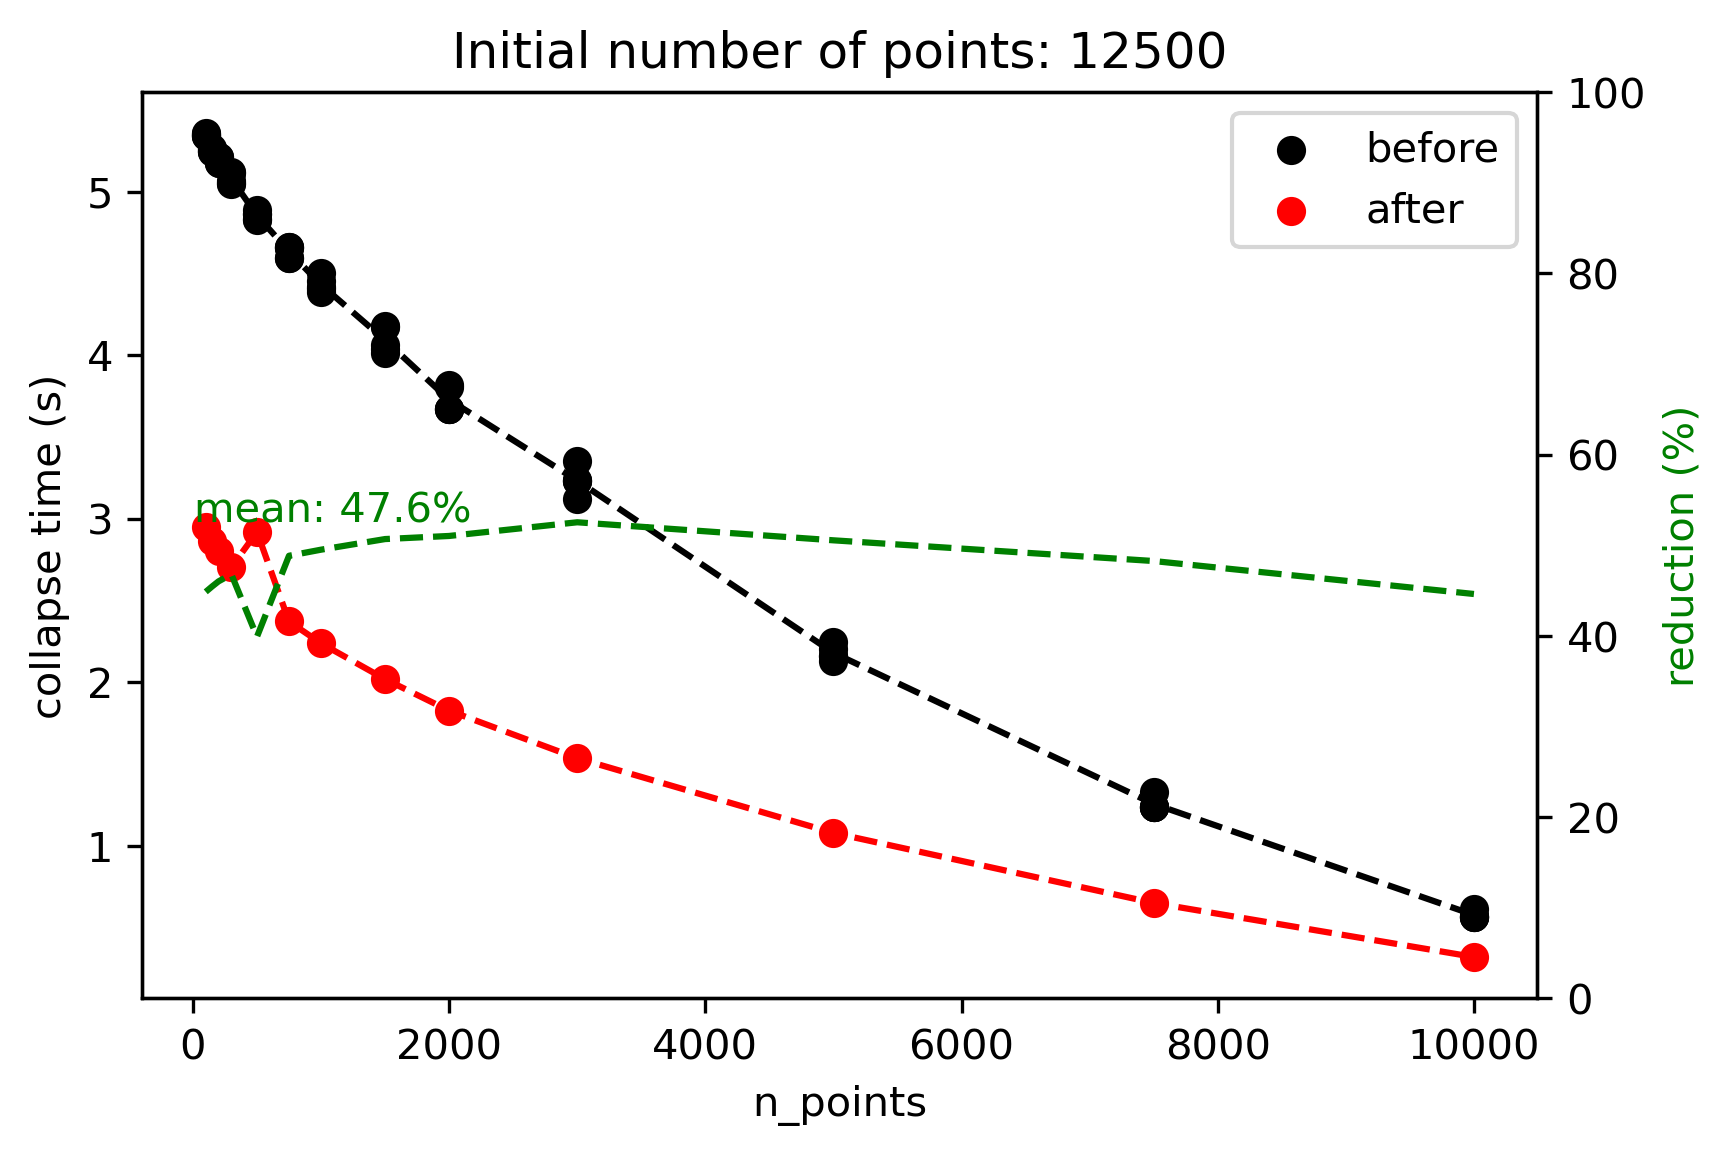

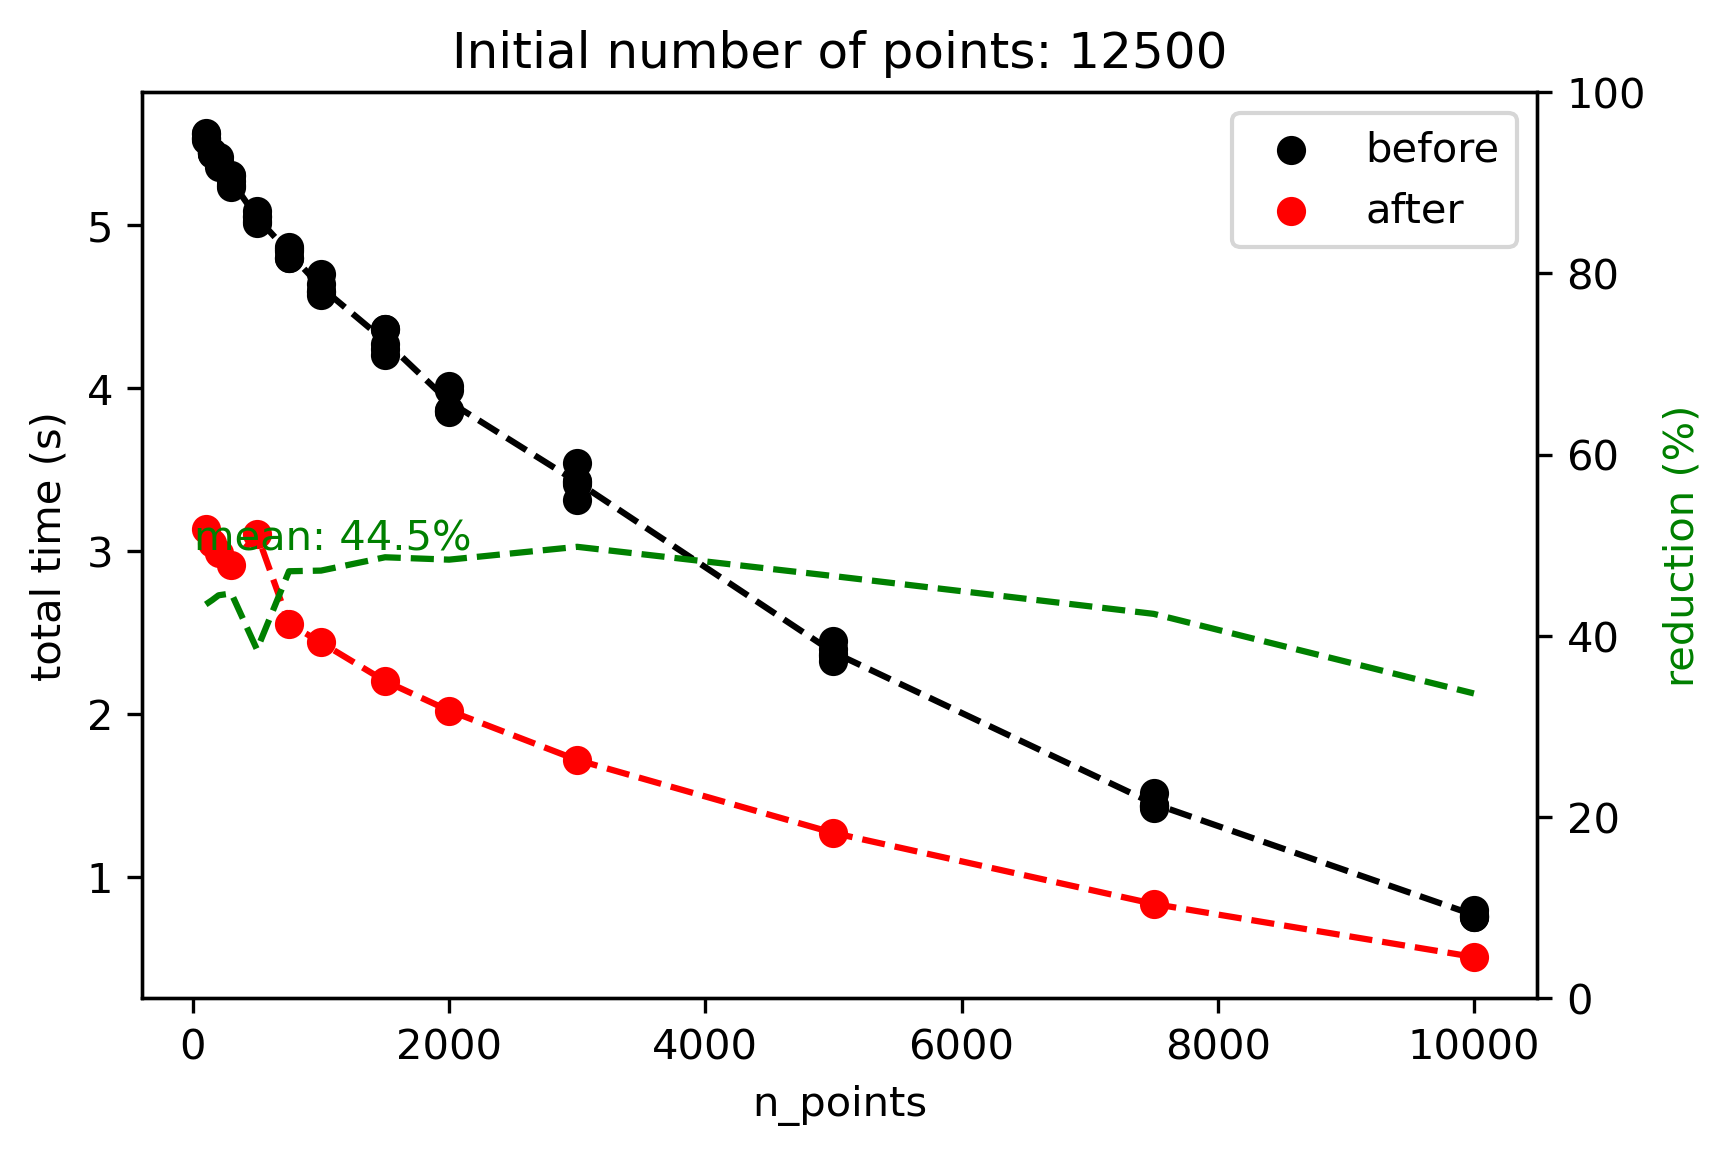

In [1]:
import matplotlib.pyplot as plt
import skshapes as sks
import numpy as np
import pickle
import pyvista

# warm up
decimator = sks.Decimation(n_points = 500, method='sks', running_time=True)
decimator.fit(sks.PolyData(pyvista.Sphere()))

# run
mesh = sks.PolyData("../scikit-shapes-draft/data/SCAPE/scapecomp/mesh000.ply")

n_runs = 1
n_points = [100, 150, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000]

running_time_record = dict()
for n in n_points:
    running_time_record[n] = []

for n in n_points:
    print(f'Running for {n} points')
    for i in range(n_runs):
        decimator = sks.Decimation(n_points=n, method='sks', running_time=True)
        decimator.fit(mesh)
        print(decimator.times)
        running_time_record[n].append(decimator.times)
    print('\n')

pickle.dump(running_time_record, open('running_time_new.pickle', 'wb'))

def make_running_time_plot(dict_before, dict_after, key, title):

    old = dict_before
    new = dict_after

    #set a good dpi for image quality
    plt.figure(dpi=300)

    avgs_old = []
    avgs_new = []

    for x in old.keys():
        tmp_old = []
        tmp_new = []
        for y in old[x]:
            p1 = plt.scatter(x, y[key], c='k')
            tmp_old.append(y[key])
        
        for y in new[x]:
            p2 = plt.scatter(x, y[key], c='r')
            tmp_new.append(y[key])
        
        avgs_old.append(np.mean(tmp_old))
        avgs_new.append(np.mean(tmp_new))

    plt.xlabel('n_points')
    plt.ylabel(f'{key} time (s)')
    plt.title('Initial number of points: 12500')
    plt.legend([p1, p2], ['before', 'after'], loc='upper right')

    avgs_old = np.array(avgs_old)
    avgs_new = np.array(avgs_new)

    reduction = 100 * (avgs_old - avgs_new) / avgs_old

    plt.plot(old.keys(), avgs_old, 'k--')
    plt.plot(old.keys(), avgs_new, 'r--')

    #add another scale for the average
    ax2 = plt.twinx()
    ax2.plot(old.keys(), reduction, 'g--')
    #write blabla on the right axis at value 10
    ax2.text(10, np.mean(reduction) + 5, f'mean: {round(np.mean(reduction), 1)}%', color='g')
    #set ax2 axis values from 0 to 100
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('reduction (%)', color='g')

    plt.savefig(title)


for key in ['collapse', 'total']:

    make_running_time_plot(
        dict_before = pickle.load(open('running_time.pickle', 'rb')),
        dict_after = running_time_record,
        key = key,
        title = f"running_time_rearrange_if_condition_{key}.png"
    )

In [2]:
percentage_running_time = {}

for n in running_time_record.keys():
        percentage_running_time[n] = {}
        total = running_time_record[n][0]['total']
        for i in ['initialize_quadrics', 'check_boundary_constraints', 'initialize_costs', 'collapse']:

                percentage_running_time[n][i] = 100 * running_time_record[n][0][i] / total

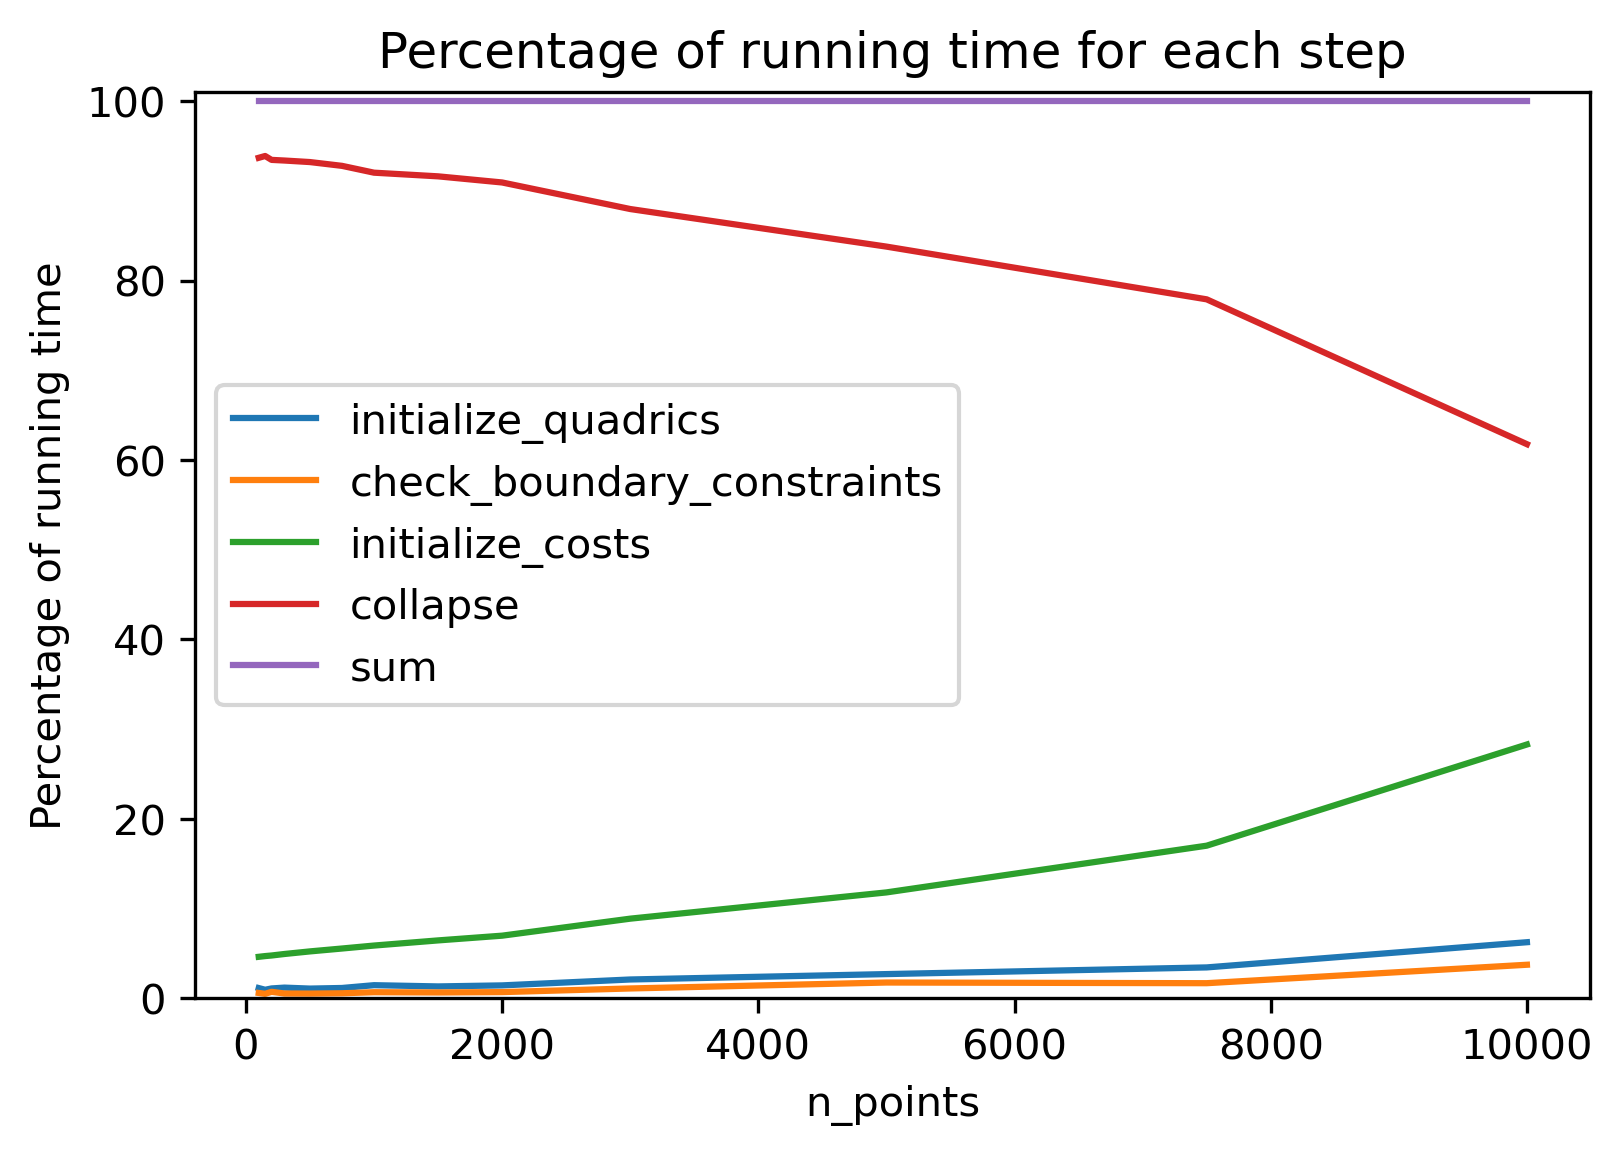

In [31]:
x = [n for n in percentage_running_time.keys()]

#set a good dpi
plt.figure(dpi=300)

for i in ['initialize_quadrics', 'check_boundary_constraints', 'initialize_costs', 'collapse']:
    y = [percentage_running_time[x][i] for x in percentage_running_time.keys()]
    plt.plot(x, y, label=i)

sum = [percentage_running_time[x]['initialize_quadrics'] + percentage_running_time[x]['check_boundary_constraints'] + percentage_running_time[x]['initialize_costs'] + percentage_running_time[x]['collapse'] for x in percentage_running_time.keys()]
plt.plot(x, sum, label='sum')

plt.legend()
plt.title('Percentage of running time for each step')
plt.xlabel('n_points')
plt.ylabel('Percentage of running time')
plt.ylim(0, 101)
plt.savefig('percentage_running_time.png')


In [11]:
running_time_record[100]

[{'initialize_quadrics': 0.035437822341918945,
  'check_boundary_constraints': 0.018256187438964844,
  'initialize_costs': 0.14510512351989746,
  'collapse': 2.948284387588501,
  'total': 3.1470835208892822}]

In [2]:
import skshapes as sks

folder = "../scikit-shapes-draft/data/SCAPE/scapecomp"
meshes = [sks.PolyData(f"{folder}/mesh{i:03d}.ply") for i in range(10)]

decimator = sks.Decimation(n_points=150, method="sks")
decimator.fit(meshes[0])

decimated_meshes = [decimator.transform(mesh) for mesh in meshes]

for i in range(len(decimated_meshes)):
    decimated_meshes[i].save(f"data/test_decimation/decimated_mesh{i:03d}.ply")

In [5]:
import os

folder = "../face_data/data/cranes/raw/"
meshes = [sks.PolyData(f"{folder}/{file}") for file in os.listdir(folder)]

decimator = sks.Decimation(target_reduction=0.99)
decimator.fit(meshes[0])

Initialize Quadrics took:  0.23317837715148926
Boundary quadrics took:  7.197599411010742
Initialize costs took:  1.1628434658050537
Collapse took:  152.66302037239075


In [6]:
5.5 / 3.2

1.71875

In [ ]:
class OrderedTable:

    def __init__

In [4]:
import numpy

a = numpy.array([1,1,2,4,7,7,11,13,13,13,15,20,25,26,27,30,45,70])
b = numpy.array([5,7,9,45])
ii = numpy.searchsorted(a, b)
a = numpy.insert(a, ii, b)

a

array([ 1,  1,  2,  4,  5,  7,  7,  7,  9, 11, 13, 13, 13, 15, 20, 25, 26,
       27, 30, 45, 45, 70])